# Survey Data with Pandas and StatsModels

Tutorial for PyCon 2025

Allen B. Downey

**Abstract**

Whether you are working with customer data or tracking election polls, Pandas and StatsModels provide powerful tools for getting insights from survey data. In this tutorial, we'll start with the basics and work up to age-period-cohort analysis and logistic regression. As examples, we'll use data from the General Social Survey to see how political beliefs have changed over the last 50 years in the United States. We'll follow the essential steps of a data science project, including loading and validating data, exploring and visualizing, modeling and predicting, and communicating results.



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPandas/blob/main/01_simpson.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the random seed so we get the same results every time
np.random.seed(17)

In [2]:
# Configure Matplotlib

plt.rcParams["figure.figsize"] = 7, 3.5
plt.rcParams["figure.dpi"] = 75
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

In [3]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    legend = options.pop("legend", True)
    loc = options.pop("loc", "best")

    # Pass options to Axis.set
    ax = plt.gca()
    ax.set(**options)

    # Add a legend if there are any labeled elements
    handles, labels = ax.get_legend_handles_labels()
    if handles and legend:
        ax.legend(handles, labels, loc=loc)

    # Tight layout is generally a good idea
    plt.tight_layout()

## Data

We will use data from the [General Social Survey](https://gss.norc.org/) (GSS).
The raw dataset is big, so I've prepared an extract, which the following cell downloads.

In [5]:
# This dataset is prepared in the GssExtract repository

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"

filename = "gss_extract_pacs_workshop.hdf"
download(DATA_PATH + filename)

In [6]:
# Solution

gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 29)

In [7]:
# Solution

gss.head()

,age,attend,ballot,class,cohort,degree,educ,fair,fear,goodlife,...,region,relig,rincome,satfin,satjob,sex,srcbelt,trust,wtssall,year
0,24.0,1.0,NaN,3.0,1948.0,3.0,16.0,2.0,NaN,NaN,...,1,1.0,NaN,1.0,NaN,1.0,5.0,1.0,1.3339,1972
1,33.0,2.0,NaN,2.0,1939.0,0.0,10.0,2.0,NaN,NaN,...,1,2.0,NaN,3.0,2.0,1.0,1.0,1.0,0.8893,1972
2,40.0,8.0,NaN,2.0,1932.0,1.0,12.0,2.0,NaN,NaN,...,1,5.0,NaN,1.0,NaN,2.0,3.0,2.0,1.3339,1972
3,24.0,2.0,NaN,2.0,1948.0,1.0,12.0,1.0,NaN,NaN,...,9,2.0,NaN,2.0,NaN,1.0,3.0,2.0,1.7786,1972
4,21.0,7.0,NaN,3.0,1951.0,1.0,12.0,1.0,NaN,NaN,...,9,1.0,NaN,1.0,NaN,2.0,2.0,NaN,1.7786,1972


In [8]:
# Solution

gss.columns

Index(['age', 'attend', 'ballot', 'class', 'cohort', 'degree', 'educ', 'fair',
       'fear', 'goodlife', 'hapmar', 'happy', 'health', 'helpful', 'id',
       'life', 'partyid', 'polviews', 'race', 'region', 'relig', 'rincome',
       'satfin', 'satjob', 'sex', 'srcbelt', 'trust', 'wtssall', 'year'],
      dtype='object')

In [9]:
def value_counts(seq, **options):
    """Make a series of values and the number of times they appear.

    Args:
        seq: sequence

    returns: Pandas Series
    """
    return pd.Series(seq).value_counts(**options).sort_index()

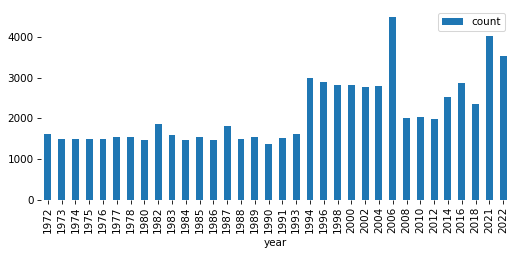

In [10]:
# Solution

value_counts(gss['year']).plot(kind='bar')
decorate()

In [11]:
# Solution

gss['age'].describe()

count    71636.000000
mean        44.985943
std         17.201666
min         18.000000
25%         30.000000
50%         43.000000
75%         58.000000
max         89.000000
Name: age, dtype: float64

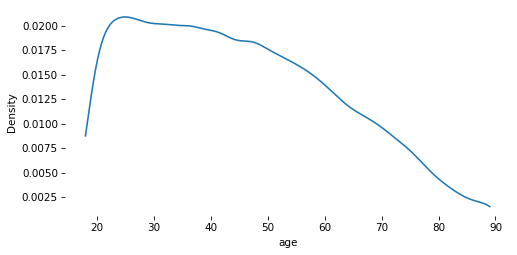

In [12]:
# Solution

sns.kdeplot(gss['age'], cut=0)
decorate()

In [13]:
# Solution

gss['cohort'].describe()

count    71987.000000
mean      1991.908095
std        561.717010
min       1883.000000
25%       1938.000000
50%       1954.000000
75%       1968.000000
max       9999.000000
Name: cohort, dtype: float64

In [14]:
# Solution

gss['cohort'] = gss['cohort'].replace(9999, np.nan)

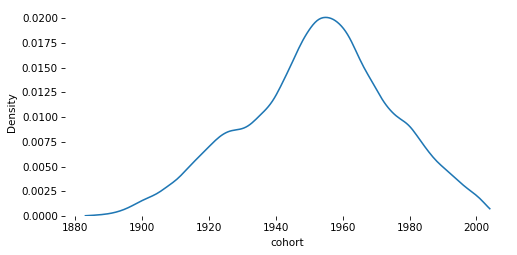

In [15]:
# Solution

sns.kdeplot(gss['cohort'], cut=0)
decorate()

In [16]:
# Solution

xtab = pd.crosstab(gss['cohort'], gss['age'])

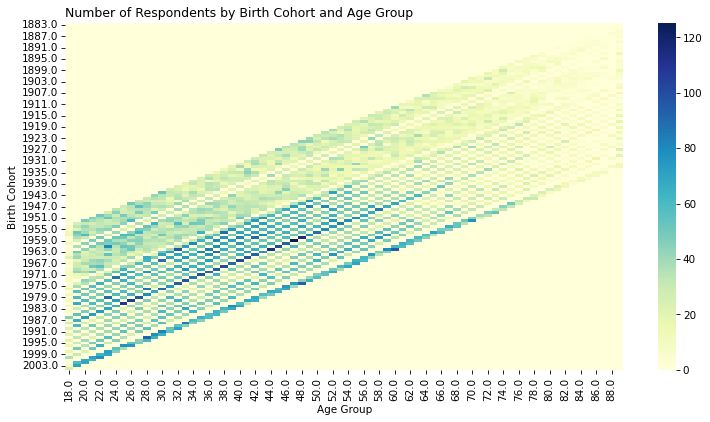

In [17]:
# Solution

plt.figure(figsize=(12, 6))
sns.heatmap(
    xtab,
    cmap="YlGnBu",
)

plt.title("Number of Respondents by Birth Cohort and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Birth Cohort")
plt.grid(False)

## Target variable

In [18]:
# https://gssdataexplorer.norc.org/variables/434/vshow

varname = 'happy'

question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

responses = ['Very happy', "Happy", 'Not too happy']

ylabel = "Percent saying 'very happy'"

In [19]:
# https://gssdataexplorer.norc.org/variables/439/vshow

varname = 'helpful'

question = """Would you say that most of the time people try to be helpful,
or that they are mostly just looking out for themselves?
"""

responses = ['Helpful', 'Look out\nfor themselves', 'Depends']

ylabel = "Percent saying 'helpful'"

In [20]:
# https://gssdataexplorer.norc.org/variables/440/vshow

varname = 'fair'

question = """Do you think most people would try to take advantage of you 
if they got a chance, or would they try to be fair?
"""

responses = ['Take advantage', 'Fair', 'Depends']

ylabel = "Percent saying 'fair'"

In [21]:
# https://gssdataexplorer.norc.org/variables/441/vshow

varname = 'trust'

question = """Generally speaking, would you say that most people can be trusted
or that you can't be too careful in dealing with people?
"""

responses = ['Trusted', "Can't be\ntoo careful", 'Depends']

ylabel = "Percent saying 'trusted'"

In [22]:
# Solution

column = gss[varname]
column

0        1.0
1        1.0
2        2.0
3        2.0
4        NaN
        ... 
72385    2.0
72386    2.0
72387    NaN
72388    NaN
72389    1.0
Name: trust, Length: 72390, dtype: float64

In [23]:
# Solution

value_counts(column, dropna=False)

trust
1.0    15783
2.0    24890
3.0     1966
NaN    29751
Name: count, dtype: int64

In [24]:
# Solution

pmf = value_counts(column, normalize=True)
pmf

trust
1.0    0.370154
2.0    0.583738
3.0    0.046108
Name: proportion, dtype: float64

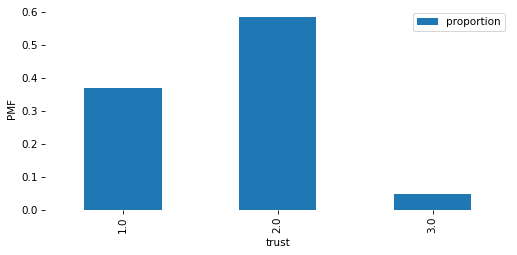

In [25]:
# Solution

pmf.plot(kind='bar')
decorate(ylabel='PMF')

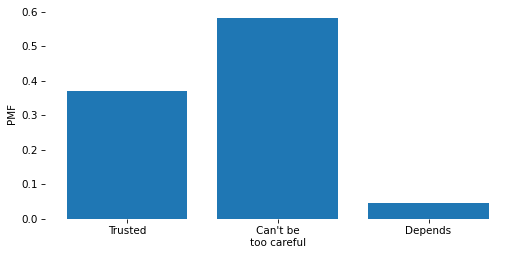

In [26]:
# Solution

plt.bar(pmf.index, pmf)
plt.xticks(pmf.index, responses)

decorate(ylabel='PMF')

## Time Series

In [27]:
# Solution

xtab = pd.crosstab(gss["year"], gss[varname], normalize='index')
xtab.head()

trust,1.0,2.0,3.0
year,,,
1972,0.463551,0.490343,0.046106
1973,0.483656,0.495664,0.020680
1975,0.391099,0.564396,0.044504
1976,0.455518,0.513043,0.031438
1978,0.396597,0.549738,0.053665


In [28]:
# Solution

gss72 = gss.query('year == 1972')
gss72.shape

(1613, 29)

In [29]:
# Solution

pmf72 = value_counts(gss72[varname], normalize=True)
pmf72

trust
1.0    0.463551
2.0    0.490343
3.0    0.046106
Name: proportion, dtype: float64

In [30]:
# Solution

time_series = xtab[1] * 100
time_series.name = "data"

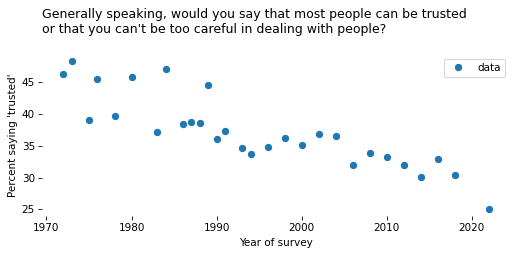

In [31]:
# Solution

time_series.plot(style='o')
decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

## Smoothing

In [32]:
# Solution

y = time_series.to_numpy()
x = time_series.index.to_numpy()

In [33]:
# Solution

from statsmodels.nonparametric.smoothers_lowess import lowess

smooth = lowess(y, x)
smooth

array([[1972.        ,   46.44336435],
       [1973.        ,   45.92462157],
       [1975.        ,   44.89138608],
       [1976.        ,   44.37506869],
       [1978.        ,   43.34021376],
       [1980.        ,   42.29915217],
       [1983.        ,   40.72900771],
       [1984.        ,   40.20411614],
       [1986.        ,   39.20980822],
       [1987.        ,   38.74261247],
       [1988.        ,   38.30428354],
       [1989.        ,   37.88875875],
       [1990.        ,   37.50837346],
       [1991.        ,   37.17928008],
       [1993.        ,   36.65662513],
       [1994.        ,   36.48118397],
       [1996.        ,   36.03439737],
       [1998.        ,   35.56517488],
       [2000.        ,   35.12889869],
       [2002.        ,   34.68957966],
       [2004.        ,   34.26108802],
       [2006.        ,   33.82664587],
       [2008.        ,   33.22849732],
       [2010.        ,   32.55719852],
       [2012.        ,   31.85749202],
       [2014.        ,   

In [34]:
# Solution

index, data = np.transpose(smooth)
smooth_series = pd.Series(data, index=index)

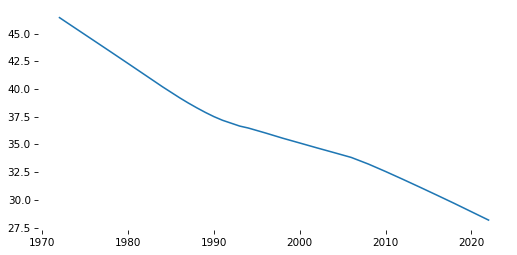

In [35]:
# Solution

smooth_series.plot()
decorate()

In [36]:
def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.to_numpy()
    x = series.index.to_numpy()

    smooth = lowess(y, x, frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [37]:
# Solution

smooth_series = make_lowess(time_series)

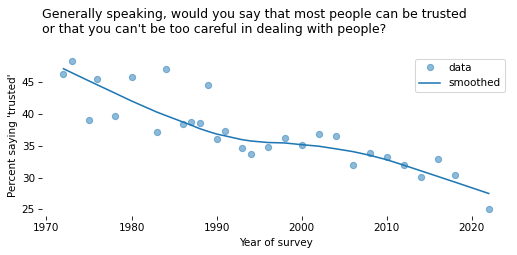

In [38]:
# Solution

time_series.plot(style='o', alpha=0.5)
smooth_series.plot(label='smoothed', color='C0')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

## Binary series

It will be useful to convert the responses to a binary variable represented with 0s and 1s.

In [39]:
# Solution

# tempting but wrong

gss['y'] = gss[varname] == 1
value_counts(gss['y'], dropna=False)

y
False    56607
True     15783
Name: count, dtype: int64

In [40]:
# Solution

gss['y'] = np.where(gss['helpful'].notna(), gss['helpful'] == 1, np.nan)
value_counts(gss['y'], dropna=False)

y
0.0    21943
1.0    20471
NaN    29976
Name: count, dtype: int64

In [41]:
# Solution

gss['y'] = gss[varname].replace([1, 2, 3], [1, 0, 0])
value_counts(gss['y'], dropna=False)

y
0.0    26856
1.0    15783
NaN    29751
Name: count, dtype: int64

## Pivot tables

In [42]:
polviews_map = {
    1: 'Liberal',
    2: 'Liberal',
    3: 'Liberal',
    4: 'Moderate',
    5: 'Conservative',
    6: 'Conservative',
    7: 'Conservative',
}

In [43]:
# Solution

gss['polviews3'] = gss['polviews'].replace(polviews_map)

In [44]:
# Solution

value_counts(gss['polviews3'], dropna=False)

polviews3
Conservative    21580
Liberal         17370
Moderate        23912
NaN              9528
Name: count, dtype: int64

In [45]:
# Solution

table = gss.pivot_table(
    index='year', columns='polviews3', values='y', aggfunc='mean'
) * 100
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1975,41.891892,39.192399,38.733706
1976,49.590164,45.961003,44.561404
1978,42.699115,43.262411,37.347295
1980,47.609562,45.896657,46.204620
1983,41.935484,31.914894,39.240506


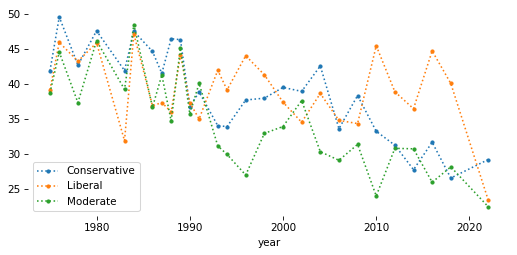

In [46]:
# Solution

table.plot(style='.:')
decorate()

## Better colors

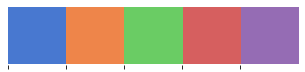

In [47]:
# Solution

muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [48]:
# Solution

color_map = {
    'Conservative': muted[3], 
    'Moderate': muted[4], 
    'Liberal': muted[0]
}

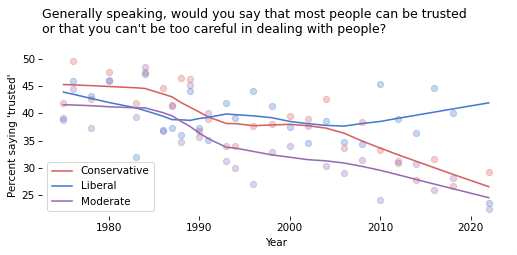

In [49]:
# Solution

groups = ['Conservative', 'Liberal', 'Moderate']

for group in groups:
    series = table[group]
    color = color_map[group]
    series.plot(style='o', label='', color=color, alpha=0.3)
    smooth = make_lowess(series)
    smooth.plot(label=group, color=color)

decorate(
    xlabel='Year',
    ylabel=ylabel,
    title=question,
)

## Groupby

Now that we have `y` as a binary variable, we have another way to compute the time series.

In [50]:
# Solution

valid = gss.dropna(subset=['y'])

In [51]:
# Solution

time_series2 = valid.groupby('year')['y'].mean() * 100
assert np.allclose(time_series, time_series2)

And the pivot table

In [52]:
# Solution

table2 = valid.groupby(['year', 'polviews3'])['y'].mean().unstack() * 100
assert np.allclose(table, table2)

There are pros and cons of each method.

## Logistic regression

In [53]:
# Solution

year_shift = gss['year'].median()
gss['x'] = gss['year'] - year_shift

In [54]:
# Solution

valid_year = gss.dropna(subset=['y', 'x'])

In [55]:
# Solution

import statsmodels.formula.api as smf

formula = 'y ~ x + I(x**2)'

model = smf.logit(formula, data=valid_year).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.653762
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                42639
Model:                          Logit   Df Residuals:                    42636
Method:                           MLE   Df Model:                            2
Date:                Sun, 04 May 2025   Pseudo R-squ.:                0.008004
Time:                        15:13:59   Log-Likelihood:                -27876.
converged:                       True   LL-Null:                       -28101.
Covariance Type:            nonrobust   LLR p-value:                 2.057e-98
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5889      0.015    -40.376      0.000      -0.618      -0.560
x             -0.0146      0.001    -19.463      0.000      -0.016      -0.013
I(x ** 2)   5.738e-05   5.13e-05      1.119      0.263   -4.31e-05       0.000
==============================================================================
"""

In [56]:
# Solution

year_range = np.arange(1972, 2026)

pred_df = pd.DataFrame(dict(x=year_range - year_shift))

pred_series = model.predict(pred_df) * 100
pred_series.index = year_range

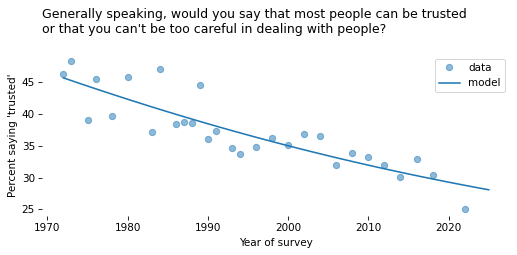

In [57]:
# Solution

time_series.plot(style='o', alpha=0.5)
pred_series.plot(label='model', color='C0')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [58]:
def fit_model(data, x_range, x_shift):
    formula = 'y ~ x + I(x**2)'
    model = smf.logit(formula, data=data).fit(disp=False)
    
    pred_df = pd.DataFrame(dict(x=x_range - x_shift))
    pred = model.predict(pred_df) * 100
    pred.index = x_range
    pred.name = 'model'

    return pred

In [59]:
# Solution

pred_series2 = fit_model(valid_year, year_range, year_shift)
assert np.allclose(pred_series, pred_series2)

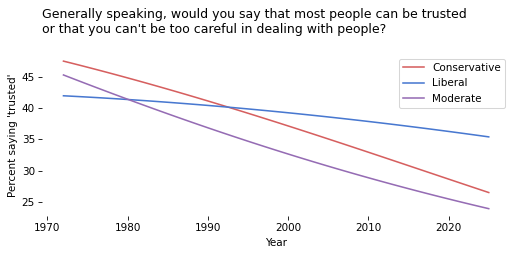

In [60]:
# Solution

for name, group in valid_year.groupby('polviews3'):
    pred_series = fit_model(group, year_range, year_shift)
    pred_series.plot(label=name, color=color_map[name])
    
decorate(
    xlabel='Year',
    ylabel=ylabel,
    title=question,
)

## Group by year of birth

In [61]:
# Solution

cohort_shift = gss['cohort'].median()

In [62]:
# Solution

gss['x'] = gss['cohort'] - cohort_shift

In [63]:
# Solution

valid_cohort = gss.dropna(subset=['y', 'x'])

In [64]:
# Solution

cohort_series = valid_cohort.groupby('cohort')['y'].mean() * 100
cohort_series.name = 'data'

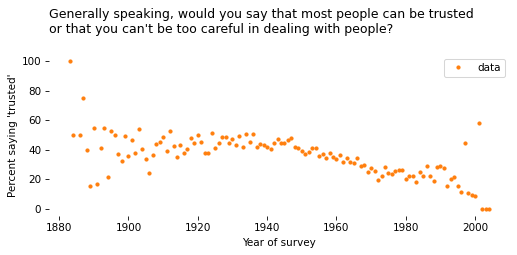

In [65]:
# Solution

cohort_series.plot(style='.', color='C1')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [66]:
# Solution

cohort_range = np.arange(1880, 2010)

pred_series = fit_model(valid_cohort, cohort_range, cohort_shift)

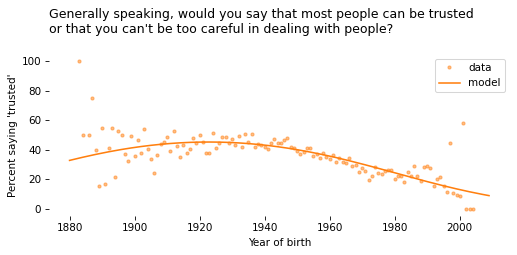

In [67]:
# Solution

cohort_series.plot(style='.', color='C1', alpha=0.5)
pred_series.plot(color='C1')

decorate(
    xlabel="Year of birth",
    ylabel=ylabel,
    title=question,
)

## Just one cohort

In [68]:
def round_into_bins(series, bin_width, low=0, high=None):
    """Rounds values down to the bin they belong in.

    series: pd.Series
    bin_width: number, width of the bins

    returns: array of bin values
    """
    if high is None:
        high = series.max()

    bins = np.arange(low, high + bin_width, bin_width)
    indices = np.digitize(series, bins)
    return bins[indices - 1]

In [69]:
gss["cohort10"] = round_into_bins(gss["cohort"], 10, 1880)
value_counts(gss["cohort10"])

cohort10
1880.0       45
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
2000.0      545
2010.0      755
Name: count, dtype: int64

In [70]:
# Solution

gss['x'] = gss['year'] - year_shift

In [71]:
# Solution

cohort_df = gss.query("cohort10 == 1940").dropna(subset=['y', 'x'])
cohort_df.shape

(6825, 33)

In [72]:
# Solution

cohort_series = cohort_df.groupby('year')['y'].mean() * 100
cohort_series.name = '1940 cohort'

In [73]:
# Solution

x_range = cohort_series.index
pred_series = fit_model(cohort_df, x_range, year_shift)

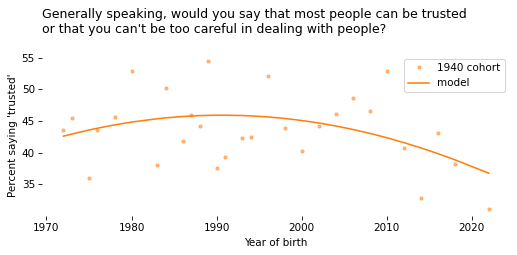

In [74]:
# Solution

cohort_series.plot(style='.', color='C1', alpha=0.5)
pred_series.plot(color='C1')

decorate(
    xlabel="Year of birth",
    ylabel=ylabel,
    title=question,
)

## All the Cohorts

In [75]:
def plot_cohort(df, cohort, color='C0'):
    cohort_df = df.query("cohort10 == @cohort").dropna(subset=['y', 'x'])

    cohort_series = cohort_df.groupby('year')['y'].mean() * 100

    year_range = cohort_series.index

    pred_series = fit_model(cohort_df, year_range, year_shift)
    x, y = pred_series.index[-1], pred_series.values[-1]
    plt.text(x, y, cohort, ha='left', va='center')

    pred_series.plot(label=cohort, color=color)

In [76]:
# Solution

first, last = 1920, 1990
subset = gss.query("@first <= cohort <= @last" )
subset.shape

(62998, 33)

In [77]:
# Solution

pred_all = fit_model(subset, year_range, year_shift)

In [78]:
# Solution

cohorts = np.sort(subset['cohort10'].unique().astype(int))
cohorts

array([1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990])

In [79]:
# Solution

cmap = plt.get_cmap('Purples')

colors = [cmap(x) for x in np.linspace(0.3, 0.9, len(cohorts))]

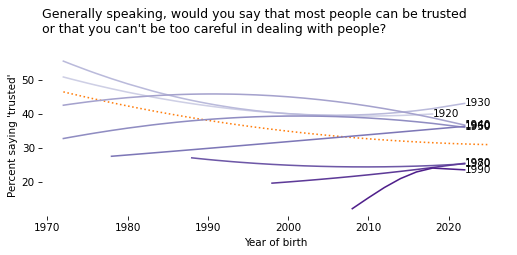

In [80]:
# Solution

pred_all.plot(ls=':', color='C1')

for cohort, color in zip(cohorts, colors):
    plot_cohort(gss, cohort, color)
    
decorate(
    xlabel="Year of birth",
    ylabel=ylabel,
    title=question,
    legend=False
)

## Simpson's Paradox

Looking at birth cohorts, the composition of the population changes over time.
The following figure shows the distribution of birth years for the respondents at the beginning of the survey in 1973, near the middle in 1990, and most recently in 2018.

In [81]:
# Solution

xtab_cohort = pd.crosstab(gss["cohort10"], gss["year"], normalize="columns")
xtab_cohort.head()

year,1972,1973,1974,1975,1976,1977,1978,1980,1982,1983,...,2004,2006,2008,2010,2012,2014,2016,2018,2021,2022
cohort10,,,,,,,,,,,,,,,,,,,,,
1880.0,0.003100,0.003989,0.008086,0.006711,0.004670,0.000000,0.003264,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1890.0,0.047737,0.038564,0.029650,0.036913,0.047365,0.027451,0.028721,0.017030,0.018817,0.005003,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1900.0,0.109733,0.099069,0.129380,0.081879,0.070047,0.090850,0.082898,0.059264,0.051075,0.038149,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1910.0,0.151891,0.158245,0.130728,0.130201,0.144096,0.124837,0.105091,0.123978,0.103226,0.093183,...,0.015647,0.007539,0.007909,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1920.0,0.223807,0.180186,0.192722,0.186577,0.158773,0.183660,0.152089,0.160082,0.148387,0.136961,...,0.038762,0.039911,0.038062,0.035225,0.025329,0.014184,0.009766,0.008518,0.0,0.0


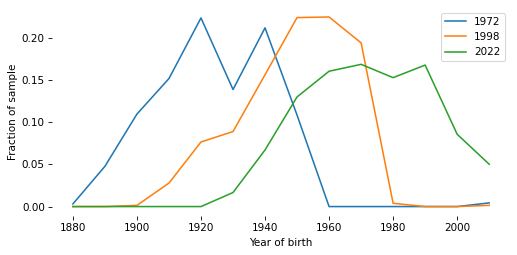

In [82]:
# Solution

xtab_cohort[1972].plot(label="1972")
xtab_cohort[1998].plot(label="1998")
xtab_cohort[2022].plot(label="2022")

decorate(xlabel="Year of birth", ylabel="Fraction of sample")

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).